<a href="https://colab.research.google.com/github/tamara-kostova/MSc_Thesis_Neuroimaging/blob/master/sam3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SAM 3 exploration

## Install necessary dependencies

In [30]:
%matplotlib inline

In [1]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib scikit-learn
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam3.git'

PyTorch version: 2.9.0+cu126
Torchvision version: 0.24.0+cu126
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam3.git to /tmp/pip-req-build-h4i2s4jo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam3.git /tmp/pip-req-build-h4i2s4jo
  Resolved https://github.com/facebookresearch/sam3.git to commit 11dec2936de97f2857c1f76b66d982d5a001155d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-py3-none-any.whl size=1865877 sha256=721f494e45b330a13b8889977095fabe149383505872ed1874e5717e20189424
  Stored in directory: /tmp/pip-ephem-wheel-cache-dnhs49pg/wheels/d0/2d/ba/135e3f5c76e53027dc9bfe15a474878249dcb047e3c0176d4e
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0


In [26]:
%matplotlib widget

In [3]:
import torch
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook. If your card doesn't support it, try float16 instead
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# inference mode for the whole notebook. Disable if you need gradients
torch.inference_mode().__enter__()

/usr/local/lib/python3.12/dist-packages/torch/backends/__init__.py:46: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  self.setter(val)


In [4]:
!pip install triton decord

In [6]:
!git clone https://github.com/facebookresearch/sam3.git
%cd sam3
!pip install -e ".[notebooks]"
%cd /content

!pip install -q supervision jupyter_bbox_widget

fatal: destination path 'sam3' already exists and is not an empty directory.
/content/sam3
Obtaining file:///content/sam3
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for sam3 (pyproject.toml) ... done
  Created wheel for sam3: filename=sam3-0.1.0-0.editable-py3-none-any.whl size=15368 sha256=cf56a80f35019e6157a9d1a5b9963f798ddc8aaf6de0556aafe82ed2c721bbe0
  Stored in directory: /tmp/pip-ephem-wheel-cache-tamdnh2t/wheels/7c/90/be/80339bb9db8655024d6c9501da4e5efc6abbda4c897f5a6c43
Successfully built sam3
  Attempting uninstall: sam3
    Found existing installation: sam3 0.1.0
    Uninstalling sam3-0.1.0:
      Successfully uninstalled sam3-0.1.0
/content


In [7]:
import os
os.path.isfile("/content/sam3/sam3/assets/bpe_simple_vocab_16e6.txt.gz")

True

In [8]:
import sam3
from sam3.sam3 import build_sam3_image_model
import os
# sam3_root = os.path.join(os.path.dirname(sam3.__file__), "..")
bpe_path = f"/content/sam3/sam3/assets/bpe_simple_vocab_16e6.txt.gz"

In [9]:
from google.colab import userdata
import os
os.environ["HF_TOKEN"] = userdata.get('HF_TOKEN')

In [12]:
import sys
!{sys.executable} -m pip install --upgrade huggingface_hub

## Build model

In [14]:
model = build_sam3_image_model(bpe_path=bpe_path)

config.json:   0%|          | 0.00/25.8k [00:00<?, ?B/s]

sam3.pt:   0%|          | 0.00/3.45G [00:00<?, ?B/s]

In [33]:
BASE_DIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging"

## Try model with a test image

In [19]:
from PIL import Image
from sam3.model.sam3_image_processor import Sam3Processor
image_path = f"{BASE_DIR}/cat.jpg"
image = Image.open(image_path)
width, height = image.size
processor = Sam3Processor(model, confidence_threshold=0.5)
inference_state = processor.set_image(image)

In [21]:
from google.colab import output
output.disable_custom_widget_manager()

found 1 object(s)


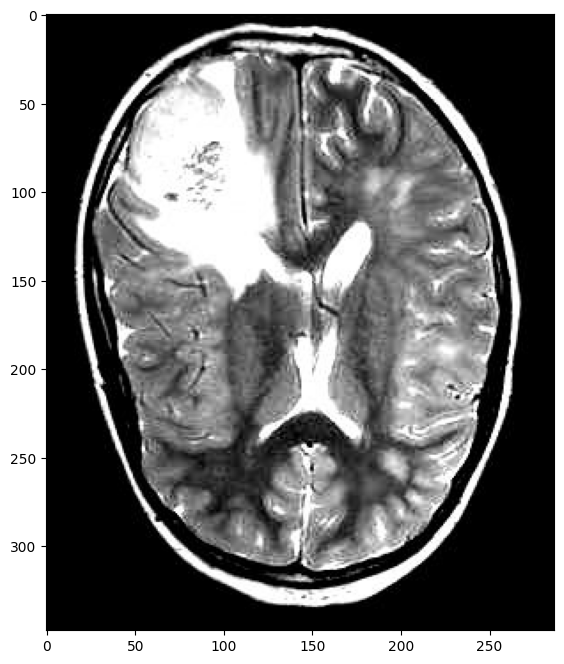

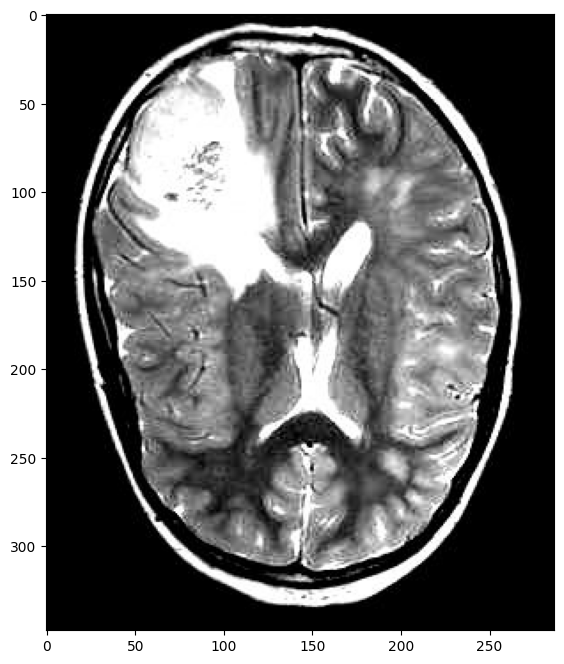

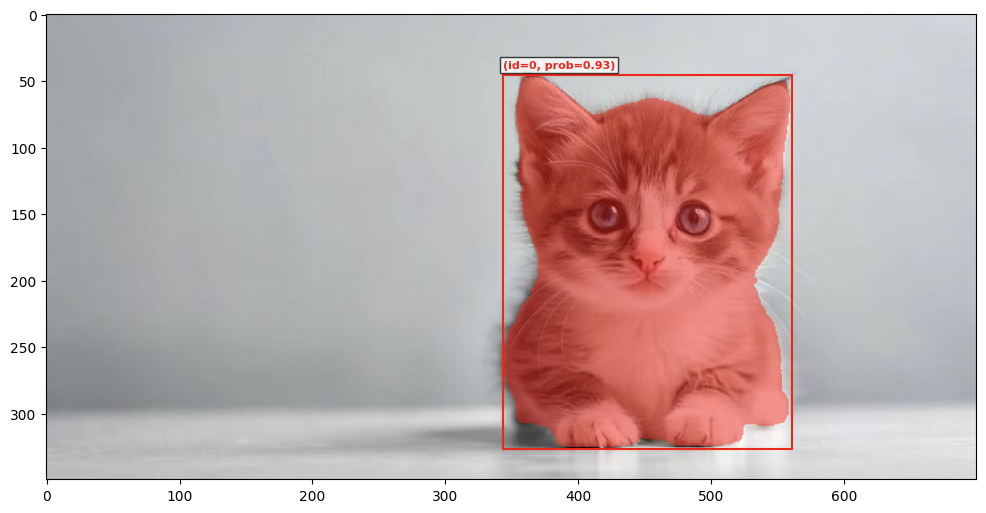

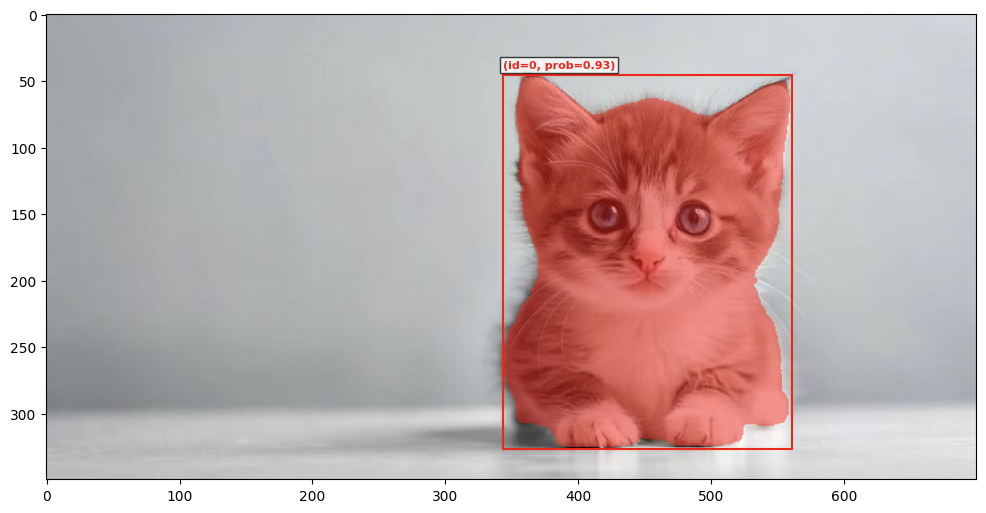

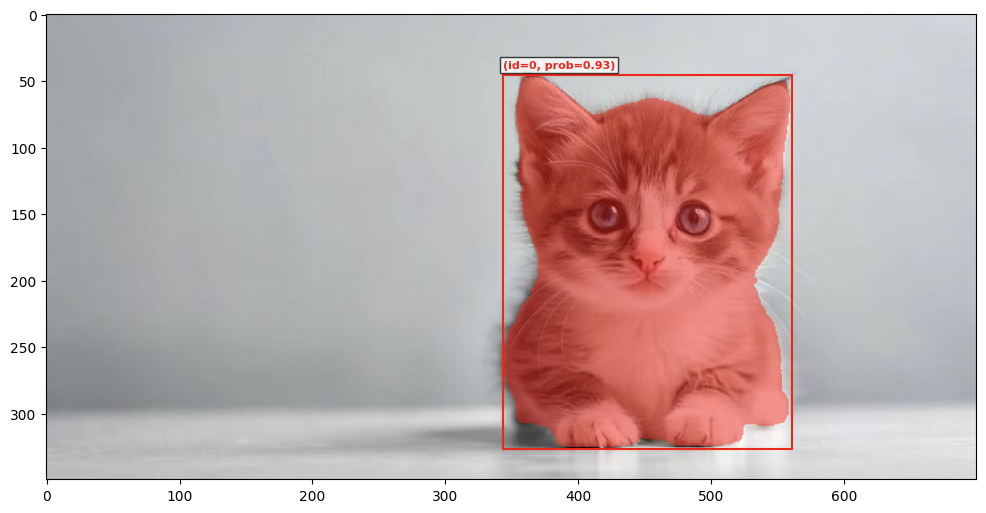

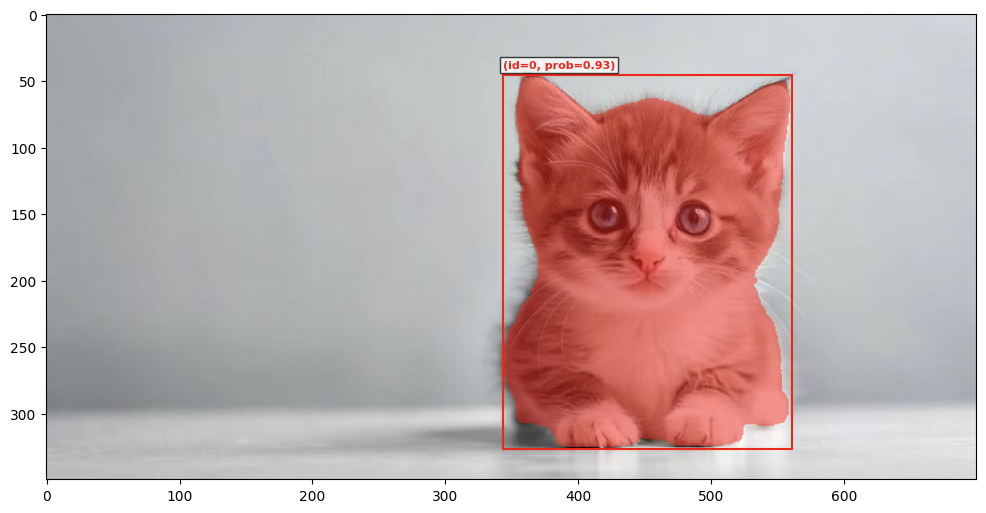

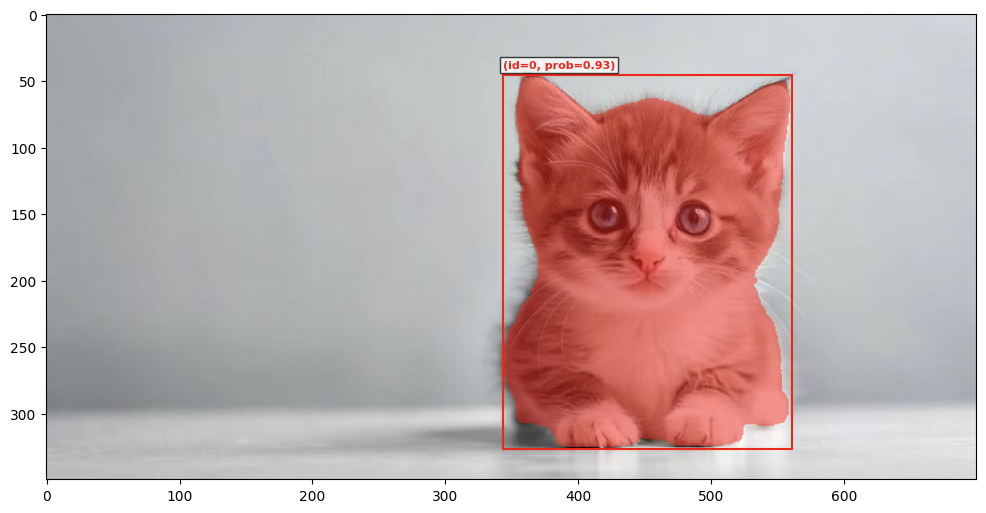

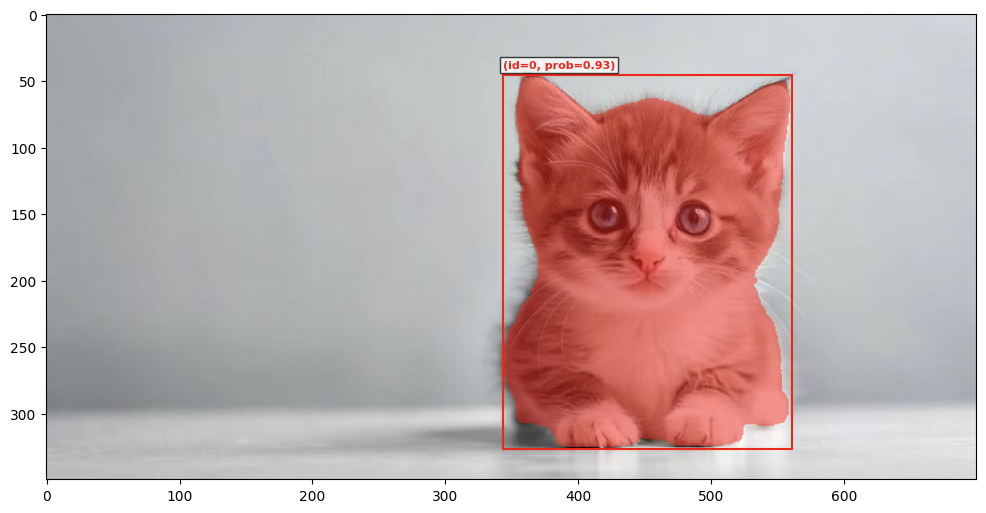

In [31]:
from sam3.visualization_utils import draw_box_on_image, normalize_bbox, plot_results
processor.reset_all_prompts(inference_state)
inference_state = processor.set_text_prompt(state=inference_state, prompt="cat")

img0 = Image.open(image_path)
plot_results(img0, inference_state)

## Test model with exampel images from MRI/CT datasets

### Imports

In [61]:
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import pandas as pd


In [80]:
BASEDIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging/"
model = build_sam3_image_model(bpe_path=bpe_path)
processor = Sam3Processor(model)
confidence_threshold = 0.25

### Datasets

In [63]:
datasets = {
    "MRI_tumor_binary": {
        "path": f"{BASEDIR}/data/split/MRI_tumor_binary_norm/test",
        "modality": "MRI",
        "classes": ["normal", "tumor"]
    },
    "MRI_tumor_multiclass": {
        "path": f"{BASEDIR}/data/split/MRI_tumor_multiclass_norm/test",
        "modality": "MRI",
        "classes": ["normal", "*oma", "*toma"]
    },
    "MRI_ms": {
        "path": f"{BASEDIR}/data/split/MRI_ms_norm/test",
        "modality": "MRI",
        "classes": ["control", "MS"]
    },
    "CT_stroke": {
        "path": f"{BASEDIR}/data/split/CT_stroke_binary_norm/test",
        "modality": "CT",
        "classes": ["normal", "stroke"]
    }
}

In [64]:

def debug_paths(dataset_name, dataset_path):
    """Debug: show exact folder structure"""
    test_path = Path(dataset_path)

    print(f"\n🔍 DEBUGGING {dataset_name}:")
    print(f"   Base path exists? {test_path.exists()}")

    if test_path.exists():
        all_items = list(test_path.iterdir())
        print(f"   Contents: {len(all_items)} items")

        for item in all_items[:10]:
            print(f"     📁 {item.name} ({'DIR' if item.is_dir() else 'FILE'})")

            if item.is_dir():
                files_in_dir = list(item.glob("*.png")) + list(item.glob("*.jpg"))
                print(f"       → {len(files_in_dir)} images")

    print("-" * 60)

In [65]:
def auto_detect_bbox(image_array, class_name):
    """Enhanced bbox detection per class"""

    if len(image_array.shape) == 3:
        gray = np.mean(image_array, axis=2)
    else:
        gray = image_array.copy()

    gray_norm = (gray - gray.min()) / (gray.max() - gray.min() + 1e-8)

    if "tumor" in class_name.lower():
        # Tumors: bright regions
        threshold = 0.35
        bright_pixels = gray_norm > threshold
    elif "ms" in class_name.lower():
        # MS lesions: small bright spots
        threshold = 0.4
        bright_pixels = gray_norm > threshold
    elif "stroke" in class_name.lower():
        # Stroke: dark regions
        threshold = 0.25
        bright_pixels = gray_norm < threshold
    elif "normal" in class_name.lower():
        # Normal: no segmentation expected
        h, w = gray.shape
        return [w//4, h//4, 3*w//4, 3*h//4]  # Center fallback
    else:
        # Default
        threshold = 0.3
        bright_pixels = gray_norm > threshold

    if bright_pixels.sum() < 50:  # Too few pixels
        h, w = gray.shape
        return [w//4, h//4, 3*w//4, 3*h//4]

    coords = np.where(bright_pixels)
    y_min, y_max = coords[0].min(), coords[0].max()
    x_min, x_max = coords[1].min(), coords[1].max()

    padding = 25
    h, w = gray.shape

    bbox = [
        max(0, x_min - padding),
        max(0, y_min - padding),
        min(w, x_max + padding),
        min(h, y_max + padding)
    ]

    return bbox

In [66]:
def evaluate_sam3_dataset(dataset_name, dataset_info, max_images_per_class=10):
    test_path = Path(dataset_info["path"])

    debug_paths(dataset_name, test_path)

    class_folders = []
    for pattern in dataset_info.get("classes", ["*"]):
        found = test_path.glob(pattern)
        class_folders.extend([f for f in found if f.is_dir()])

    print(f"\nFound {len(class_folders)} class folders: {[f.name for f in class_folders]}")

    all_results = []

    for class_folder in class_folders:
        class_name = class_folder.name

        if "normal" in class_name.lower() or "control" in class_name.lower():
            print(f"  ⏭️  Skipping: {class_name}")
            continue

        image_files = list(class_folder.glob("*.png")) + list(class_folder.glob("*.jpg"))

        if len(image_files) == 0:
            print(f"  ⚠️  No images in {class_name}")
            continue

        print(f"  🖼️  Processing {class_name}: {len(image_files)} images")

        for img_path in tqdm(image_files[:max_images_per_class], desc=f"  {class_name}"):
            try:
                image = Image.open(img_path)
                if image.mode != 'RGB':
                    image = image.convert('RGB')

                image_array = np.array(image)
                bbox = auto_detect_bbox(image_array, class_name)

                inference_state = processor.set_image(image)
                prompt = "segment the tumor" if "tumor" in class_name.lower() else "segment the lesion"
                inference_state = processor.set_text_prompt(state=inference_state, prompt=prompt)

                output = processor.predict_masks(
                    state=inference_state,
                    confidence_threshold=confidence_threshold
                )

                masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

                if len(masks) > 0:
                    best_idx = np.argmax(scores)
                    mask = masks[best_idx]
                    score = scores[best_idx]

                    all_results.append({
                        'dataset': dataset_name,
                        'class': class_name,
                        'image': img_path.name,
                        'bbox': bbox,
                        'n_objects': len(masks),
                        'best_score': float(score),
                        'mask_ratio': float(mask.mean()),
                        'success': True
                    })
                else:
                    all_results.append({
                        'dataset': dataset_name,
                        'class': class_name,
                        'image': img_path.name,
                        'bbox': bbox,
                        'n_objects': 0,
                        'best_score': 0.0,
                        'mask_ratio': 0.0,
                        'success': False
                    })

            except Exception as e:
                all_results.append({
                    'dataset': dataset_name,
                    'class': class_name,
                    'image': img_path.name,
                    'error': str(e),
                    'success': False
                })

    if len(all_results) == 0:
        results_df = pd.DataFrame([{
            'dataset': dataset_name,
            'note': 'No images or folders found',
            'success': False
        }])
    else:
        results_df = pd.DataFrame(all_results)

    print(f"\n  ✅ {dataset_name}: {len(results_df)} images processed")
    print(f"  📊 Success rate: {results_df['success'].mean():.1% if 'success' in results_df.columns else 'N/A'}")

    return results_df

In [81]:

print("🔍 DEBUGGING ALL PATHS FIRST...")
for dataset_name, info in datasets.items():
    debug_paths(dataset_name, info["path"])

print("\n🚀 RUNNING SAM3 EVALUATION...")
all_results = {}

for dataset_name, info in datasets.items():
    try:
        results_df = evaluate_sam3_dataset(dataset_name, info)
        all_results[dataset_name] = results_df
    except Exception as e:
        print(f"❌ Error in {dataset_name}: {e}")

🔍 DEBUGGING ALL PATHS FIRST...

🔍 DEBUGGING MRI_tumor_binary:
   Base path exists? True
   Contents: 2 items
     📁 normal (DIR)
       → 225 images
     📁 tumor (DIR)
       → 225 images
------------------------------------------------------------

🔍 DEBUGGING MRI_tumor_multiclass:
   Base path exists? True
   Contents: 12 items
     📁 Carcinoma (DIR)
       → 2 images
     📁 Germinoma (DIR)
       → 7 images
     📁 Glioma (DIR)
       → 48 images
     📁 Granuloma (DIR)
       → 2 images
     📁 Meduloblastoma (DIR)
       → 2 images
     📁 Meningioma (DIR)
       → 170 images
     📁 Neurocitoma (DIR)
       → 43 images
     📁 Normal (DIR)
       → 18 images
     📁 Other (DIR)
       → 7 images
     📁 Papiloma (DIR)
       → 20 images
------------------------------------------------------------

🔍 DEBUGGING MRI_ms:
   Base path exists? True
   Contents: 2 items
     📁 Control (DIR)
       → 187 images
     📁 MS (DIR)
       → 399 images
-------------------------------------------------

  tumor: 100%|██████████| 10/10 [00:04<00:00,  2.08it/s]



  ✅ MRI_tumor_binary: 10 images processed
❌ Error in MRI_tumor_binary: Invalid format specifier '.1% if 'success' in results_df.columns else 'N/A'' for object of type 'float'

🔍 DEBUGGING MRI_tumor_multiclass:
   Base path exists? True
   Contents: 12 items
     📁 Carcinoma (DIR)
       → 2 images
     📁 Germinoma (DIR)
       → 7 images
     📁 Glioma (DIR)
       → 48 images
     📁 Granuloma (DIR)
       → 2 images
     📁 Meduloblastoma (DIR)
       → 2 images
     📁 Meningioma (DIR)
       → 170 images
     📁 Neurocitoma (DIR)
       → 43 images
     📁 Normal (DIR)
       → 18 images
     📁 Other (DIR)
       → 7 images
     📁 Papiloma (DIR)
       → 20 images
------------------------------------------------------------

Found 12 class folders: ['Carcinoma', 'Germinoma', 'Glioma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Papiloma', 'Schwannoma', 'Ttuberculoma', 'Meduloblastoma', 'Neurocitoma']
  🖼️  Processing Carcinoma: 2 images


  Carcinoma: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


  🖼️  Processing Germinoma: 7 images


  Germinoma: 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]


  🖼️  Processing Glioma: 48 images


  Glioma: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


  🖼️  Processing Granuloma: 2 images


  Granuloma:  50%|█████     | 1/2 [00:00<00:00,  1.00it/s]


KeyboardInterrupt: 

In [88]:
import torch
import gc

torch.cuda.empty_cache()
gc.collect()

print("GPU memory cleared!")
print(f"Free GPU memory: {torch.cuda.memory_reserved()/1e9:.1f}GB")

GPU memory cleared!
Free GPU memory: 15.0GB


In [90]:
from pathlib import Path
import matplotlib.pyplot as plt

BASEDIR = "/content/drive/MyDrive/MSc_Thesis_Neuroimaging/"

tumor_base = Path(f"{BASEDIR}/data/split/MRI_tumor_binary_norm/test")

subfolders = [f for f in tumor_base.iterdir() if f.is_dir()]
print(f"Subfolders: {[f.name for f in subfolders]}")

for folder in subfolders:
    images = list(folder.glob("*.png")) + list(folder.glob("*.jpg"))
    print(f"  {folder.name}: {len(images)} images")
    if len(images) > 0:
        first_img = images[0]
        print(f"    First image: {first_img}")

tumor_images = []
for folder in subfolders:
    if 'tumor' in folder.name.lower() or 'ms' in folder.name.lower() or 'stroke' in folder.name.lower():
        images = list(folder.glob("*.png")) + list(folder.glob("*.jpg"))
        tumor_images.extend(images[:3])  # 3 per folder

print(f"\n🧠 Found {len(tumor_images)} pathology images for testing")

if len(tumor_images) == 0:
    print("❌ No pathology images found. List all images:")
    all_images = list(tumor_base.rglob("*.png")) + list(tumor_base.rglob("*.jpg"))
    print(f"All images: {len(all_images)}")
    if len(all_images) > 0:
        tumor_images = all_images[:5]
        print("Using first 5 images...")

if len(tumor_images) > 0:
    test_image_path = tumor_images[0]
    print(f"\n🧪 TESTING SAM3 ON: {test_image_path}")

    image = Image.open(test_image_path).convert('RGB')
    print(f"Image size: {image.size}, Mode: {image.mode}")

    try:
        inference_state = processor.set_image(image)
        output = processor.set_text_prompt(
            state=inference_state,
            prompt="segment the tumor"
        )

        masks, boxes, scores = output["masks"], output["boxes"], output["scores"]

        print(f"✅ SAM3 RESULTS:")
        print(f"  Masks found: {len(masks)}")
        print(f"  Scores: {[f'{s:.3f}' for s in scores]}")

        if len(masks) > 0:
            best_mask = masks[0]
            print(f"  Best mask ratio: {best_mask.mean():.1%}")

            # Visualize
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image)
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(image)
            plt.imshow(best_mask, alpha=0.6, cmap='Reds')
            plt.title(f"SAM3 Segmentation\nScore: {scores[0]:.3f}\nMask: {best_mask.mean():.1%}")
            plt.axis('off')

            plt.tight_layout()
            plt.savefig("sam3_tumor_test.png", dpi=150)
            plt.show()
        else:
            print("❌ No masks found - try lower confidence threshold")

    except Exception as e:
        print(f"❌ SAM3 Error: {e}")
        print("Full traceback:")
        import traceback
        traceback.print_exc()
else:
    print("❌ No images found anywhere!")


Subfolders: ['normal', 'tumor']
  normal: 225 images
    First image: /content/drive/MyDrive/MSc_Thesis_Neuroimaging/data/split/MRI_tumor_binary_norm/test/normal/no431.jpg
  tumor: 225 images
    First image: /content/drive/MyDrive/MSc_Thesis_Neuroimaging/data/split/MRI_tumor_binary_norm/test/tumor/y431.jpg

🧠 Found 3 pathology images for testing

🧪 TESTING SAM3 ON: /content/drive/MyDrive/MSc_Thesis_Neuroimaging/data/split/MRI_tumor_binary_norm/test/tumor/y431.jpg
Image size: (224, 224), Mode: RGB
❌ SAM3 Error: CUDA out of memory. Tried to allocate 1.60 GiB. GPU 0 has a total capacity of 14.74 GiB of which 700.12 MiB is free. Process 103307 has 14.05 GiB memory in use. Of the allocated memory 9.75 GiB is allocated by PyTorch, and 4.18 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/c

Traceback (most recent call last):
  File "/tmp/ipython-input-515847824.py", line 42, in <cell line: 0>
    inference_state = processor.set_image(image)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/_contextlib.py", line 120, in decorate_context
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/content/sam3/sam3/model/sam3_image_processor.py", line 59, in set_image
    state["backbone_out"] = self.model.backbone.forward_image(image)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/sam3/sam3/model/vl_combiner.py", line 80, in forward_image
    return activation_ckpt_wrapper(self._forward_image_no_act_ckpt)(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/sam3/sam3/model/act_ckpt_utils.py", line 88, in act_ckpt_wrapper
    ret = module(*args, **kwargs)
          ^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/sam3/sam3/model/vl_combin

In [72]:
if dataset_summary:
    summary_df = pd.DataFrame(dataset_summary)
    print(f"\n{'='*80}")
    print("📋 THESIS TABLE - SAM3 PERFORMANCE")
    print(f"{'='*80}")
    print(summary_df.to_markdown(index=False))

    # Save
    summary_df.to_csv("sam3_thesis_results.csv", index=False)
    print("\n💾 Saved to `sam3_thesis_results.csv`")

    print(f"\n🎉 OVERALL: {total_success}/{total_images} = {(total_success/total_images):.1%} success!")
else:
    print("\n❌ No results to summarize")


❌ No results to summarize
